In [1]:
import gc
import os
import time
import datetime
import warnings
from itertools import combinations
from warnings import simplefilter
import lightgbm as lgb
import catboost as cbt
from sklearn.feature_selection import RFE

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error 
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Please use caps lock capital letters while filling in parameters
    """
    
    # Data preparation
    version_nb         = 3
    is_gpu             = True
    # device             = torch.device('cuda' if torch.cuda.is_available() and gpu_switch else 'cpu')
    state              = 42
    num_workers        = 4

    # BEFORE SUBMIT, CHECK SETTINGS
    is_test_mode       = False
    test_mode_frac     = 10
    is_offline         = True
    is_tuning          = True
    testing_days       = 2

    target             = 'target'    
    path               = '/kaggle/input/optiver-trading-at-the-close'
    train_path         = f'{path}/train.csv'
    test_path          = f'{path}/example_test_files/test.csv'
    model_path         = f'' if not is_offline else f'{path}/'
    
    TRAINING           = True
    INFERENCE          = False
    TUNING             = True
    
    methods            = ['LGBM',]
    # methods            = ['CBT']

    plt_path = f'fig/turning'

# Data Loading and Preprocessing 






In [3]:
# 📂 Read the dataset from a CSV file using Pandas
df = pd.read_csv(CFG.train_path)
if CFG.is_test_mode:
    df = df[df['stock_id'] < test_mode_frac]

# 🧹 Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
df.reset_index(drop=True, inplace=True)

# 📏 Get the shape of the DataFrame (number of rows and columns)
df_shape = df.shape
print(df_shape)

(5237892, 17)


# Memory Optimization

In [4]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df


 # Parallel Triplet Imbalance Calculation

In [5]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features


# Feature Generation Functions 

In [6]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    df["size_imbalance_bid"] = df.eval("imbalance_size / bid_size")
    df["size_imbalance_ask"] = df.eval("imbalance_size / ask_size")
    df["matched_size_bid_ask"] = df.eval("matched_size / (bid_size+ask_size)")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

            if window == 1:
                continue

            date_ids = df['date_id'].unique()
            agg_func = ['mean', 'sum']
            moving_li = []
            
            for date in date_ids:
                moving_li.append(
                    df[df['date_id'] == date].groupby('stock_id')[col].rolling(window).agg(agg_func).reset_index().set_index('level_1')[agg_func]
                )
            df[[f'{col}_moving_average_{window}', f'{col}_moving_sum_{window}']] = pd.concat(moving_li)[agg_func]
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'market_urgency', 'imbalance_momentum', 'size_imbalance']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    # --- add
    # Calculate diff prices
    for c in combinations(prices, 2):
        df[f'{c[0]}_{c[1]}_diff'] = df.eval(f'({c[0]} - {c[1]})')

    return df.replace([np.inf, -np.inf], 0)

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    df = other_features(df)
    gc.collect()  
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id", 'ask_price_bid_price_diff']]
    # feature_name = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'ask_size', 'wap', 'volume', 'liquidity_imbalance', 'matched_imbalance', 'size_imbalance', 'size_imbalance_ask', 'matched_size_bid_ask', 'reference_price_near_price_imb', 'bid_price_wap_imb', 'ask_price_bid_price_wap_imb2', 'ask_price_wap_reference_price_imb2', 'bid_price_wap_reference_price_imb2', 'matched_size_bid_size_ask_size_imb2', 'matched_size_bid_size_imbalance_size_imb2', 'matched_size_ask_size_imbalance_size_imb2', 'imbalance_momentum', 'price_pressure', 'market_urgency', 'all_prices_mean', 'all_prices_std', 'all_sizes_skew', 'all_sizes_kurt', 'matched_size_shift_1', 'matched_size_ret_1', 'matched_size_shift_10', 'matched_size_ret_10', 'imbalance_size_moving_average_2', 'imbalance_size_moving_sum_2', 'imbalance_size_ret_3', 'imbalance_size_ret_10', 'imbalance_size_moving_average_10', 'imbalance_size_moving_sum_10', 'reference_price_moving_average_10', 'imbalance_buy_sell_flag_shift_1', 'imbalance_buy_sell_flag_shift_2', 'imbalance_buy_sell_flag_moving_average_2', 'imbalance_buy_sell_flag_moving_sum_2', 'imbalance_buy_sell_flag_shift_3', 'imbalance_buy_sell_flag_moving_average_3', 'imbalance_buy_sell_flag_moving_sum_3', 'imbalance_buy_sell_flag_shift_10', 'imbalance_buy_sell_flag_moving_average_10', 'imbalance_buy_sell_flag_moving_sum_10', 'ask_price_diff_1', 'bid_price_diff_10', 'bid_size_diff_10', 'market_urgency_diff_3', 'market_urgency_diff_10', 'size_imbalance_diff_2', 'size_imbalance_diff_3', 'size_imbalance_diff_10', 'reference_price_near_price_diff', 'reference_price_wap_diff', 'bid_price_wap_diff', 'minute', 'global_median_size']
    return df[feature_name]

In [7]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

## Data Splitting

In [8]:
df_train = df.copy()
del df

In [9]:
global_stock_id_feats = {
    "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
    "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
    "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
    "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
    "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
    "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
}
if CFG.TRAINING:
    df_train_feats = generate_all_features(df_train)
    df_train_feats = reduce_mem_usage(df_train_feats)

    feature_name = list(df_train_feats.columns)
    print(f'Feature length = {len(feature_name)}')

Feature length = 165


## LightGBM

In [12]:
lgb_params = {
    'objective': 'mae',  # 最小化させるべき損失関数
    'metric': 'mae',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
    'random_state': CFG.state,  # 乱数シード
    'boosting_type': 'gbdt',  # boosting_type
    'n_estimators': 10000 if CFG.is_test_mode else 500,
    # 'early_stopping_round': 100 if CFG.is_test_mode else 10,  # ここでearly_stoppingを指定
    'verbose': -1,
    'importance_type': 'gain',
    'n_jobs': CFG.num_workers,
    'device': 'gpu' if CFG.is_gpu else 'cpu',
}
model = lgb.LGBMRegressor(**lgb_params)

In [13]:
selector = RFE(model, n_features_to_select=100, step=1, verbose=True)
selector.fit(df_train_feats, df_train['target'])

ValueError: Item wrong length 165 instead of 5237892.

In [19]:
selected_feature_name = df_train_feats.columns[selector.get_support()]
len(selected_feature_name)

100

In [20]:
selected_feature_name

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'far_price', 'near_price',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'mid_price',
       'matched_imbalance', 'size_imbalance', 'size_imbalance_ask',
       'matched_size_bid_ask', 'reference_price_ask_price_imb',
       'reference_price_bid_price_imb', 'reference_price_wap_imb',
       'far_price_near_price_imb', 'near_price_ask_price_imb',
       'near_price_bid_price_imb', 'near_price_wap_imb',
       'ask_price_bid_price_imb', 'bid_price_wap_imb',
       'ask_price_bid_price_wap_imb2',
       'ask_price_bid_price_reference_price_imb2',
       'ask_price_wap_reference_price_imb2',
       'bid_price_wap_reference_price_imb2',
       'matched_size_bid_size_imbalance_size_imb2',
       'matched_size_ask_size_imbalance_size_imb2', 'imbalance_momentum',
       'price_spread', 'spread_intensity', 'price_pressure', 'market_urgency',
       'all_prices_mean', 

In [13]:
if CFG.TRAINING and 'LGBM' in CFG.methods:
    lgb_params = {
        "objective": "mae",
        "n_estimators": 6000 if not CFG.is_test_mode else 500,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.00871,
        'max_depth': 11,
        "n_jobs": 4,
        "device": 'gpu' if CFG.is_gpu else 'cpu',
        "verbosity": -1,
        "importance_type": "gain",
        'seed': CFG.state,
    }
    feature_name = list(df_train_feats.columns)
    print(f"Feature length = {len(feature_name)}")
    
    num_folds = 5
    fold_size = 480 // num_folds
    gap = 5
    
    lgb_models = []
    scores = []
    
    model_save_path = f'{CFG.model_path}lgb_model' 
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    
    date_ids = df_train['date_id'].values
    
    for i in range(num_folds):
        start = i * fold_size
        end = start + fold_size
        if i < num_folds - 1:  # No need to purge after the last fold
            purged_start = end - 2
            purged_end = end + gap + 2
            train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
        else:
            train_indices = (date_ids >= start) & (date_ids < end)
        
        test_indices = (date_ids >= end) & (date_ids < end + fold_size)
        
        df_fold_train = df_train_feats[train_indices]
        df_fold_train_target = df_train['target'][train_indices]
        df_fold_valid = df_train_feats[test_indices]
        df_fold_valid_target = df_train['target'][test_indices]
    
        print(f"Fold {i+1} Model Training")
        
        # Train a LightGBM model for the current fold
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        lgb_model.fit(
            df_fold_train[feature_name],
            df_fold_train_target,
            eval_set=[(df_fold_valid[feature_name], df_fold_valid_target)],
            callbacks=[
                lgb.callback.early_stopping(stopping_rounds=100),
                lgb.callback.log_evaluation(period=100),
            ],
        )
    
        lgb_models.append(lgb_model)
        # Save the model to a file
        model_filename = os.path.join(model_save_path, f'lgb_cv{i+1}.txt')
        lgb_model.booster_.save_model(model_filename)
        print(f"Model for fold {i+1} saved to {model_filename}")
    
        # Evaluate model performance on the validation set
        fold_predictions = lgb_model.predict(df_fold_valid[feature_name])
        fold_score = mean_absolute_error(fold_predictions, df_fold_valid_target)
        scores.append(fold_score)
        print(f"Fold {i+1} MAE: {fold_score}")
    
        # Free up memory by deleting fold specific variables
        del df_fold_train, df_fold_train_target, df_fold_valid, df_fold_valid_target
        gc.collect()
    
    # Calculate the average best iteration from all regular folds
    average_best_iteration = int(np.mean([model.best_iteration_ for model in lgb_models]))
    
    # Update the lgb_params with the average best iteration
    final_model_params = lgb_params.copy()
    final_model_params['n_estimators'] = average_best_iteration
    
    print(f"Training final model with average best iteration: {average_best_iteration}")
    
    # Train the final model on the entire dataset
    final_model = lgb.LGBMRegressor(**final_model_params)
    final_model.fit(
        df_train_feats[feature_name],
        df_train['target'],
        callbacks=[
            lgb.callback.log_evaluation(period=500),
        ],
    )
    
    # Append the final model to the list of models
    lgb_models.append(final_model)
    
    # Save the final model to a file
    final_model_filename = os.path.join(model_save_path, 'lgb_fin.txt')
    final_model.booster_.save_model(final_model_filename)
    print(f"Final model saved to {final_model_filename}")
    
    # Now 'models' holds the trained models for each fold and 'scores' holds the validation scores
    print(f"Average MAE across all folds: {np.mean(scores)}")

    os.makedirs(f'{model_save_path}/scores', exist_ok=True)
    np.savetxt(f'{model_save_path}/scores/lgbm_{datetime.datetime.now()}.txt', scores)

Feature length = 165
Fold 1 Model Training


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 7.10098
[200]	valid_0's l1: 7.05589
[300]	valid_0's l1: 7.03369
[400]	valid_0's l1: 7.01605
[500]	valid_0's l1: 7.00091
[600]	valid_0's l1: 6.9881
[700]	valid_0's l1: 6.9771
[800]	valid_0's l1: 6.96702
[900]	valid_0's l1: 6.95807
[1000]	valid_0's l1: 6.95004
[1100]	valid_0's l1: 6.94242
[1200]	valid_0's l1: 6.93534
[1300]	valid_0's l1: 6.92939
[1400]	valid_0's l1: 6.92307
[1500]	valid_0's l1: 6.91681
[1600]	valid_0's l1: 6.911
[1700]	valid_0's l1: 6.90548
[1800]	valid_0's l1: 6.89946
[1900]	valid_0's l1: 6.89401
[2000]	valid_0's l1: 6.88856
[2100]	valid_0's l1: 6.88392
[2200]	valid_0's l1: 6.87924
[2300]	valid_0's l1: 6.87436
[2400]	valid_0's l1: 6.86936
[2500]	valid_0's l1: 6.86438
[2600]	valid_0's l1: 6.85936
[2700]	valid_0's l1: 6.85463
[2800]	valid_0's l1: 6.84979
[2900]	valid_0's l1: 6.84442
[3000]	valid_0's l1: 6.83963
[3100]	valid_0's l1: 6.83447
[3200]	valid_0's l1: 6.82963
[3300]	valid_0's l1: 6.

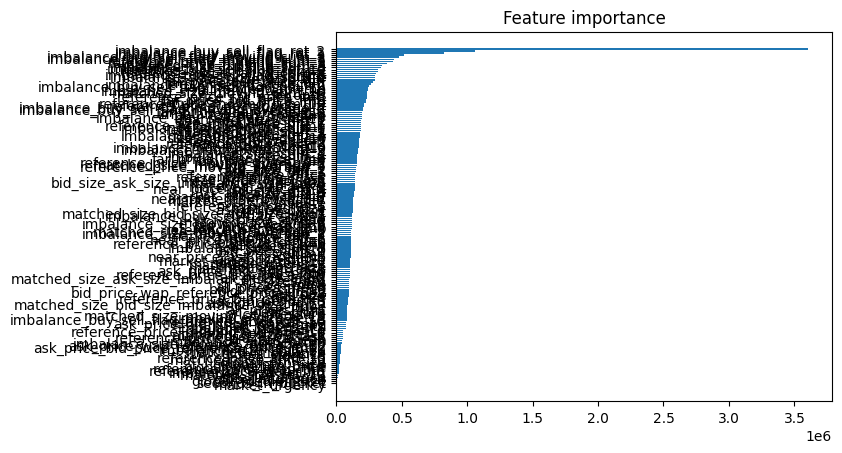

In [25]:
# 特徴量重要度の取得
importances = final_model.feature_importances_
feature_names = df_train_feats.columns

In [39]:
feature_importances = pd.DataFrame({'feature': feature_names, 'val': importances}).set_index('feature').sort_values('val', ascending=False)

<Axes: ylabel='feature'>

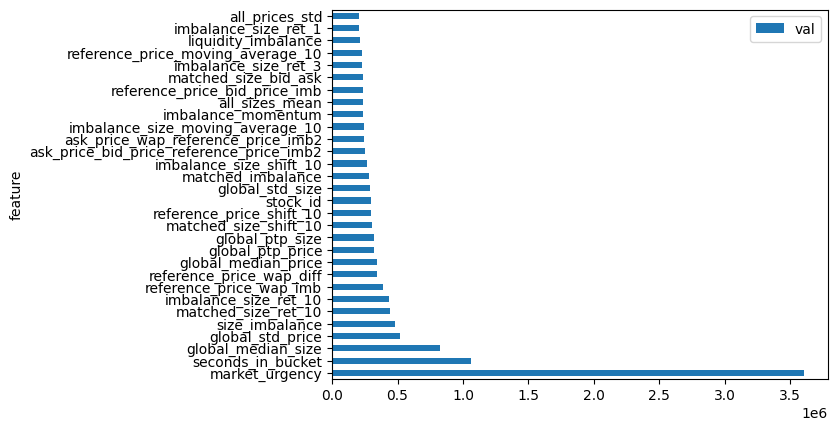

In [41]:
feature_importances.head(30).plot.barh()

In [47]:
with pd.option_context('display.max_rows', 300):
    display(feature_importances)

,val
feature,
market_urgency,3.607298e+06
seconds_in_bucket,1.057872e+06
global_median_size,8.239998e+05
global_std_price,5.175953e+05
size_imbalance,4.775818e+05
matched_size_ret_10,4.434794e+05
imbalance_size_ret_10,4.369299e+05
reference_price_wap_imb,3.862220e+05
reference_price_wap_diff,3.471193e+05


In [19]:
feature_names

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size',
       ...
       'bid_price_wap_diff', 'dow', 'seconds', 'minute', 'global_median_size',
       'global_std_size', 'global_ptp_size', 'global_median_price',
       'global_std_price', 'global_ptp_price'],
      dtype='object', length=165)

In [21]:
importances.shape

(165,)

## Catboost

In [14]:
if CFG.TRAINING and 'CBT' in CFG.methods:
    cbt_params = {
        'task_type'           : 'GPU' if CFG.is_gpu else 'CPU',
        'objective'           : 'MAE',
        'eval_metric'         : 'MAE',
        'bagging_temperature' : 0.5,
    #     'colsample_bylevel'   : 0.7,
        'iterations'          : 500 if not CFG.is_test_mode else 100,
        'early_stopping_rounds' : 50 if not CFG.is_test_mode else 10,
        'learning_rate'       : 0.065,
        'max_depth'           : 7,
        'l2_leaf_reg'         : 1.5,
        'min_data_in_leaf'    : 1000,
        'random_strength'     : 0.65, 
        'verbose'             : 0,
        'use_best_model'      : True,
        'random_seed'         : CFG.state,
    }
    feature_name = list(df_train_feats.columns)
    print(f"Feature length = {len(feature_name)}")
    
    num_folds = 5
    fold_size = 480 // num_folds
    gap = 5
    
    cbt_models = []
    scores = []
    
    model_save_path = f'{CFG.model_path}cbt_model' 
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    
    date_ids = df_train['date_id'].values
    
    for i in range(num_folds):
        start = i * fold_size
        end = start + fold_size
        if i < num_folds - 1:  # No need to purge after the last fold
            purged_start = end - 2
            purged_end = end + gap + 2
            train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
        else:
            train_indices = (date_ids >= start) & (date_ids < end)
        
        test_indices = (date_ids >= end) & (date_ids < end + fold_size)
        
        df_fold_train = df_train_feats[train_indices]
        df_fold_train_target = df_train['target'][train_indices]
        df_fold_valid = df_train_feats[test_indices]
        df_fold_valid_target = df_train['target'][test_indices]
        cbt_train = cbt.Pool(df_fold_train, df_fold_train_target)
        cbt_valid = cbt.Pool(df_fold_valid, df_fold_valid_target)
    
        print(f"Fold {i+1} Model Training")
        
        # Train a LightGBM model for the current fold
        cbt_model = cbt.CatBoostRegressor(**cbt_params)
        cbt_model.fit(
            cbt_train,
            eval_set=[cbt_valid],
        )
    
        cbt_models.append(cbt_model)
        # Save the model to a file
        model_filename = os.path.join(model_save_path, f'cbt_cv{i+1}.cbm')
        cbt_model.save_model(model_filename)
        print(f"Model for fold {i+1} saved to {model_filename}")
    
        # Evaluate model performance on the validation set
        fold_predictions = cbt_model.predict(df_fold_valid[feature_name])
        fold_score = mean_absolute_error(fold_predictions, df_fold_valid_target)
        scores.append(fold_score)
        print(f"Fold {i+1} MAE: {fold_score}")
    
        # Free up memory by deleting fold specific variables
        del df_fold_train, df_fold_train_target, df_fold_valid, df_fold_valid_target
        gc.collect()
    
    # Calculate the average best iteration from all regular folds
    average_best_iteration = int(np.mean([model.get_best_iteration() for model in cbt_models]))
    
    # Update the lgb_params with the average best iteration
    final_model_params = cbt_params.copy()
    final_model_params['iterations'] = average_best_iteration
    final_model_params['use_best_model'] = False
    
    print(f"Training final model with average best iteration: {average_best_iteration}")
    
    # Train the final model on the entire dataset
    final_model = cbt.CatBoostRegressor(**final_model_params)
    final_model.fit(
        df_train_feats[feature_name],
        df_train['target'],
    )
    
    # Append the final model to the list of models
    cbt_models.append(final_model)
    
    # Save the final model to a file
    final_model_filename = os.path.join(model_save_path, 'cbt_fin.cbm')
    final_model.save_model(final_model_filename)
    print(f"Final model saved to {final_model_filename}")
    
    # Now 'models' holds the trained models for each fold and 'scores' holds the validation scores
    print(f"Average MAE across all folds: {np.mean(scores)}")

    os.makedirs(f'{model_save_path}/scores', exist_ok=True)
    np.savetxt(f'{model_save_path}/scores/cbt_{datetime.datetime.now()}.txt', scores)

In [15]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

if CFG.INFERENCE:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()
    
    lgb_models = [
#         lgb.Booster(model_file='/kaggle/input/optiver-lgbm/lgb_model/lgb_cv1.txt'),
#         lgb.Booster(model_file='/kaggle/input/optiver-lgbm/lgb_model/lgb_cv2.txt'),
        lgb.Booster(model_file='/kaggle/input/optiver-lgbm/lgb_model/lgb_cv3.txt'),
        lgb.Booster(model_file='/kaggle/input/optiver-lgbm/lgb_model/lgb_cv4.txt'),
        lgb.Booster(model_file='/kaggle/input/optiver-lgbm/lgb_model/lgb_cv5.txt'),
        lgb.Booster(model_file='/kaggle/input/optiver-lgbm/lgb_model/lgb_fin.txt'),
    ]
    cbt_models = [
#         cbt.CatBoostRegressor().load_model('/kaggle/input/optiver-catboost/cbt_model/cbt_cv1.cbm'),
#         cbt.CatBoostRegressor().load_model('/kaggle/input/optiver-catboost/cbt_model/cbt_cv2.cbm'),
#         cbt.CatBoostRegressor().load_model('/kaggle/input/optiver-catboost/cbt_model/cbt_cv3.cbm'),
#         cbt.CatBoostRegressor().load_model('/kaggle/input/optiver-catboost/cbt_model/cbt_cv4.cbm'),
        cbt.CatBoostRegressor().load_model('/kaggle/input/optiver-catboost/cbt_model/cbt_cv5.cbm'),
        cbt.CatBoostRegressor().load_model('/kaggle/input/optiver-catboost/cbt_model/cbt_fin.cbm'),
    ]
    # Weights for each fold model
    lgb_model_weights = [0.1, 0.2, 0.3, 0.4]
    cbt_model_weights = [0.4, 0.6]
#     lgb_model_weights = [1/len(lgb_models)] * len(lgb_models)
#     cbt_model_weights = [1/len(cbt_models)] * len(cbt_models)
    
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        feat = generate_all_features(cache)[-len(test):]

        if test.currently_scored.iloc[0] == False:
            sample_prediction['target'] = 0
            env.predict(sample_prediction)
            counter += 1
            qps.append(time.time() - now_time)
            if counter % 10 == 0:
                print(counter, 'qps:', np.mean(qps))
            continue
                    
        feat = feat.drop(columns=['currently_scored'])

        # Generate predictions for each model and calculate the weighted average
        lgb_predictions = np.zeros(len(test))
        for model, weight in zip(lgb_models, lgb_model_weights):
            lgb_predictions += weight * model.predict(feat)

        lgb_predictions = zero_sum(lgb_predictions, test['bid_size']+test['ask_size'])
        clipped_predictions = np.clip(lgb_predictions, y_min, y_max)
        sample_prediction['target'] = clipped_predictions
        # CatBoost
        cbt_predictions = np.zeros(len(test))
        for model, weight in zip(cbt_models, cbt_model_weights):
            cbt_predictions += weight * model.predict(feat)

        cbt_predictions = zero_sum(cbt_predictions, test['bid_size']+test['ask_size'])
        clipped_predictions = np.clip(cbt_predictions, y_min, y_max)
        sample_prediction['target'] = 0.4 * clipped_predictions + 0.6 * sample_prediction['target']

        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")